## 🍕🥩🍣 FoodVision Mini – Classifying Food with Deep Learning

## 👋 What's This Project About?


This is a fun little project where I train a deep learning model to recognize whether a food image is pizza, steak, or sushi. I'm using a small, focused subset of the `Food101` dataset to keep things simple and fast.

I'll first train a model from scratch using just 10% of the data, then move on to transfer learning with powerful models like EfficientNet and ViT. After will train on 20% of data.

In the end, I'll compare all models and will deploy it on Hugging Face Space

In [91]:
# Importing PyTorch and setting up device-agnostic code
import torch
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"

torch.__version__

'2.6.0+cu124'

## 1. Get data : Only 10% of Food101 Datasets
First things first we need some data. We're going to start small.

Because we're not looking to train the biggest model or use the biggest dataset yet.

Machine learning is an iterative process, start small, get something working and increase when necessary.

The data we're going to be using is a subset of the Food101 dataset. https://docs.pytorch.org/vision/main/generated/torchvision.datasets.Food101.html

`Food101` is popular computer vision benchmark as it contains 1000 images of 101 different kinds of foods, totaling 101,000 images (75,750 train and 25,250 test).

Original Food101 dataset and paper website.
: https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/

Let's write some code to download the formatted data from GitHub.  [The data in the github are some random images downloaded from Food101 dataset.].

Data are already filtered and are present in this location of my github, so, will be downloading data from there:
https://github.com/krrish9973/pytorch-deep-learning/tree/main/data

In [92]:
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/krrish9973/pytorch-deep-learning/raw/refs/heads/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...")
        zip_ref.extractall(image_path)

data/pizza_steak_sushi directory exists.


## 2. Become one with the data (data preparation)
Dataset downloaded!

Time to become one with it.

This is another important step before building a model.

As Abraham Lossfunction said...
**"If I had 8 hours to build a machine learning model, I'd spend the first 6 hours preparing my dataset."**


**Abraham Lossfunction**



We can inspect what's in our data directory by writing a small helper function to walk through each of the subdirectories and count the files present.

To do so, we'll use Python's in-built `os.walk()`.


In [93]:
import os
def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.
  Args:
    dir_path (str or pathlib.Path): target directory

  Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [94]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'.
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'.
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'.
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'.
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'.
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'.
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'.


It looks like we've got about 75 images per training class and 25 images per testing class.

That should be enough to get started.

Remember, these images are subsets of the original Food101 dataset.

While we're at it, let's setup our training and testing paths.



In [95]:
# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

### 2.1 Visualize an image

Let's write some code to:

1. Get all of the image paths using `pathlib.Path.glob()` to find all of the files ending in .jpg.
2. Pick a random image path using Python's `random.choice()`.
3. Get the image class name using `pathlib.Path.parent.stem`.
4. And since we're working with images, we'll open the random image path using `PIL.Image.open()` (PIL stands for Python Image Library).
5. We'll then show the image and print some metadata.


In [96]:
image_path

PosixPath('data/pizza_steak_sushi')

Random image path: data/pizza_steak_sushi/train/sushi/3353428.jpg
Image class: sushi
Image height: 512
Image width: 512


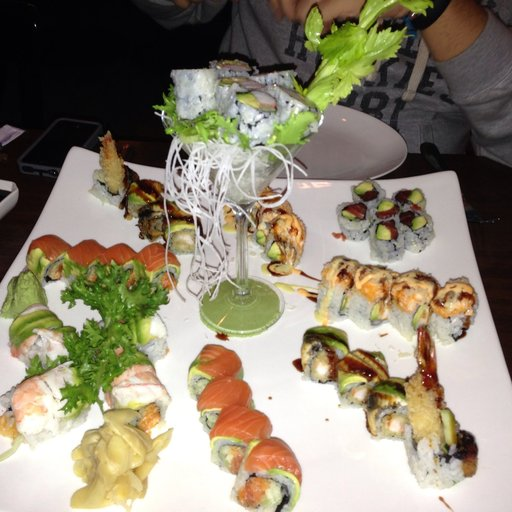

In [97]:
import random
from PIL import Image

# Set seed
random.seed(42) # Random Seeds

# 1. Get all image paths (* means "any combination")
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Get random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

We can do the same with matplotlib.pyplot.imshow(), except we have to convert the image to a NumPy array first.

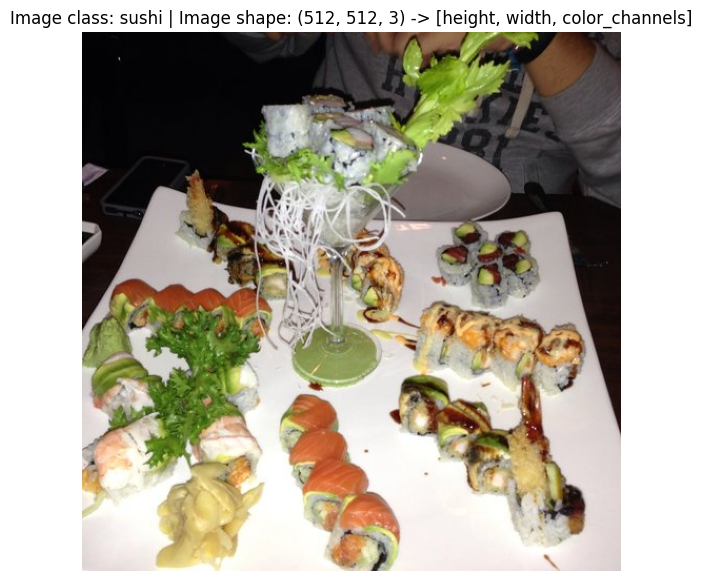

In [98]:
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False);

### 2.2. Transforming data
Now what if we wanted to load our image data into PyTorch?

Before we can use our image data with PyTorch we need to:

Turn it into `tensors` (numerical representations of our images).
Turn it into a `torch.utils.data.Dataset` and subsequently a `torch.utils.data.DataLoader`, we'll call these Dataset and DataLoader for short.

Since we're working with a vision problem, we'll be looking at `torchvision.datasets` for our data loading functions as well as `torchvision.transforms` for preparing our data.

Let's import some base libraries.


In [99]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

### 2.3 Transforming data with torchvision.transforms
We've got folders of images but before we can use them with PyTorch, we need to convert them into tensors.

One of the ways we can do this is by using the `torchvision.transforms` module.

`torchvision.transforms` contains many pre-built methods for formatting images, turning them into tensors and even manipulating them for data augmentation (the practice of altering data to make it harder for a model to learn.

To get experience with `torchvision.transforms`, let's write a series of transform steps that:

1. Resize the images using `transforms.Resize()` (from about 512x512 to 64x64, the same shape as the images on the CNN Explainer website). https://poloclub.github.io/cnn-explainer/
2. Flip our images randomly on the horizontal using `transforms.RandomHorizontalFlip()` (this could be considered a form of data augmentation because it will artificially change our image data).
3. Turn our images from a PIL image to a PyTorch tensor using `transforms.ToTensor()`.
4. We can compile all of these steps using `torchvision.transforms.Compose()`.

In [100]:
# Write transform for image
data_transform = transforms.Compose([
    # Resize the images to 64x64
    transforms.Resize(size=(64, 64)),
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5), # p = probability of flip, 0.5 = 50% chance
    # Turn the image into a torch.Tensor
    transforms.ToTensor() # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0
])

Now we've got a composition of transforms, let's write a function to try them out on various images.

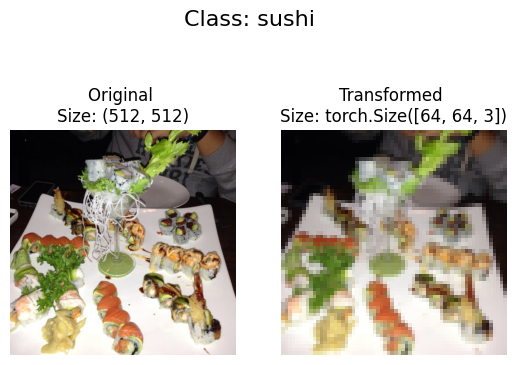

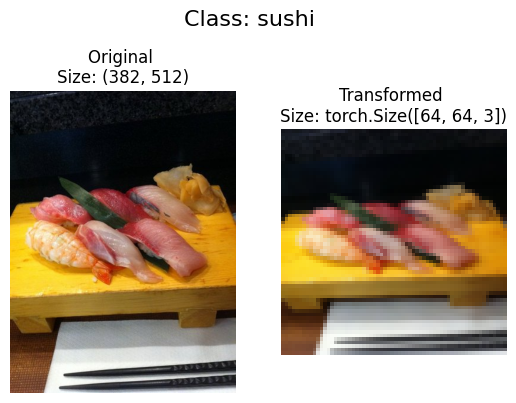

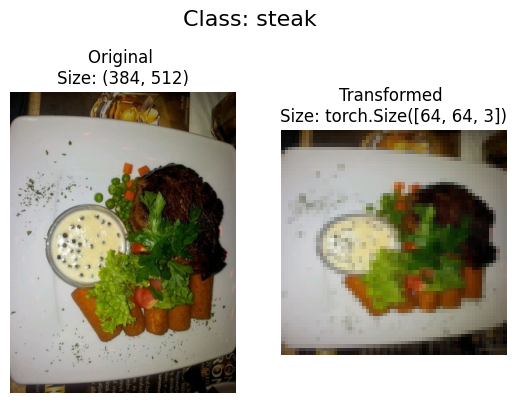

In [101]:
def plot_transformed_images(image_paths, transform, n=3, seed=42):
    """Plots a series of random images from image_paths.

    Will open n image paths from image_paths, transform them
    with transform and plot them side by side.

    Args:
        image_paths (list): List of target image paths.
        transform (PyTorch Transforms): Transforms to apply to images.
        n (int, optional): Number of images to plot. Defaults to 3.
        seed (int, optional): Random seed for the random generator. Defaults to 42.
    """
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            # Transform and plot image
            # Note: permute() will change shape of image to suit matplotlib
            # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
            transformed_image = transform(f).permute(1, 2, 0)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_path_list,
                        transform=data_transform,
                        n=3)

Generally, the larger the shape of the image, the more information a model can recover.

For example, an image of size [256, 256, 3] will have 16x more pixels than an image of size [64, 64, 3] ((256*256*3)/(64*64*3)=16).

However, the tradeoff is that more pixels requires more computations.


### 2.4. Loading Image Data Using ImageFolder
Since our data is in standard image classification format, we can use the class `torchvision.datasets.ImageFolder`.

Where we can pass it the file path of a target image directory as well as a series of transforms we'd like to perform on our images.

Let's test it out on our data folders `train_dir` and `test_dir` passing in `transform=data_transform`**bold text** to turn our images into tensors.


In [102]:
# Use ImageFolder to create dataset(s)
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir, # target folder of images
                                  transform=data_transform, # transforms to perform on data (images)
                                  target_transform=None) # transforms to perform on labels (if necessary)

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)

print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 225
    Root location: data/pizza_steak_sushi/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 75
    Root location: data/pizza_steak_sushi/test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )


It looks like PyTorch has registered our Dataset's.

Let's inspect them by checking out the classes and class_to_idx attributes as well as the lengths of our training and test sets.


In [103]:
# Get class names as a list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [104]:
# Can also get class names as a dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [105]:
# Check the lengths
len(train_data), len(test_data)

(225, 75)

We can index on our `train_data` and `test_data` Dataset's to find samples and their target labels.

In [106]:
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor:\n{img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
tensor([[[0.1176, 0.1216, 0.1255,  ..., 0.0980, 0.1020, 0.1137],
         [0.1294, 0.1294, 0.1294,  ..., 0.0980, 0.0980, 0.1059],
         [0.1333, 0.1333, 0.1333,  ..., 0.0941, 0.0980, 0.1020],
         ...,
         [0.1686, 0.1647, 0.1686,  ..., 0.1255, 0.1098, 0.1098],
         [0.1686, 0.1647, 0.1686,  ..., 0.1098, 0.0941, 0.0902],
         [0.1647, 0.1647, 0.1686,  ..., 0.0980, 0.0863, 0.0863]],

        [[0.0588, 0.0588, 0.0588,  ..., 0.0745, 0.0706, 0.0745],
         [0.0627, 0.0627, 0.0627,  ..., 0.0745, 0.0706, 0.0745],
         [0.0706, 0.0706, 0.0706,  ..., 0.0745, 0.0745, 0.0706],
         ...,
         [0.2392, 0.2392, 0.2510,  ..., 0.1373, 0.1333, 0.1255],
         [0.2314, 0.2392, 0.2510,  ..., 0.1255, 0.1176, 0.1098],
         [0.2275, 0.2353, 0.2431,  ..., 0.1137, 0.1059, 0.1020]],

        [[0.0196, 0.0196, 0.0157,  ..., 0.0902, 0.0902, 0.0941],
         [0.0196, 0.0157, 0.0196,  ..., 0.0902, 0.0863, 0.0902],
         [0.0196, 0.0157, 0.0157,  ..., 0.09


Our images are now in the form of a tensor (with shape [3, 64, 64]) and the labels are in the form of an integer relating to a specific class (as referenced by the class_to_idx attribute).

How about we plot a single image tensor using matplotlib?

We'll first have to to permute (rearrange the order of its dimensions) so it's compatible.

Right now our image dimensions are in the format CHW (color channels, height, width) but matplotlib prefers HWC (height, width, color channels).MM

Original shape: torch.Size([3, 64, 64]) -> [color_channels, height, width]
Image permute shape: torch.Size([64, 64, 3]) -> [height, width, color_channels]


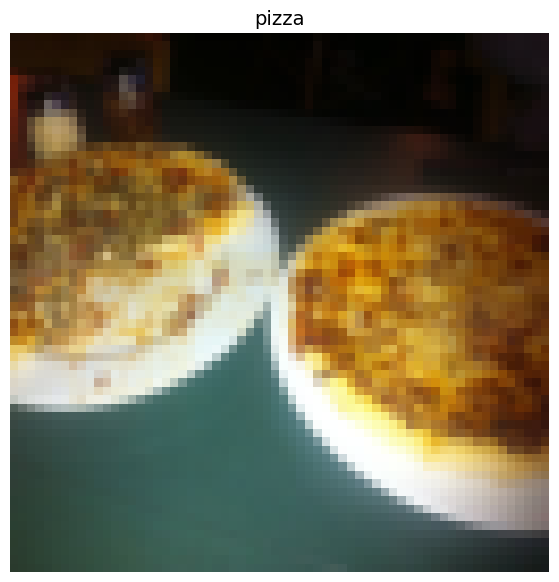

In [107]:
# Rearrange the order of dimensions
img_permute = img.permute(1, 2, 0)

# Print out different shapes (before and after permute)
print(f"Original shape: {img.shape} -> [color_channels, height, width]")
print(f"Image permute shape: {img_permute.shape} -> [height, width, color_channels]")

# Plot the image
plt.figure(figsize=(10, 7))
plt.imshow(img.permute(1, 2, 0))
plt.axis("off")
plt.title(class_names[label], fontsize=14);

### 2.5 Turn loaded images into DataLoader's

In [108]:
# Turn train and test Datasets into DataLoaders
from torch.utils.data import DataLoader
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=1, # how many samples per batch?
                              num_workers=1, # how many subprocesses to use for data loading? (higher = more)
                              shuffle=True) # shuffle the data?

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=1,
                             num_workers=1,
                             shuffle=False) # don't usually need to shuffle testing data

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7c67dc439550>,
 <torch.utils.data.dataloader.DataLoader at 0x7c67db96f910>)

In [109]:
img, label = next(iter(train_dataloader))

# Batch size will now be 1, try changing the batch_size parameter above and see what happens
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([1])


## 3. Model 0: TinyVGG without data augmentation

In [110]:
class TinyVGG(nn.Module):
    """
    Model architecture copying TinyVGG from:
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=1), # options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from?
            # It's because each layer of our network compresses and changes the shape of our input data.
            nn.Linear(in_features=hidden_units*16*16,
                      out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
        x = self.conv_block_1(x)
        # print(x.shape)
        x = self.conv_block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x
        # return self.classifier(self.conv_block_2(self.conv_block_1(x))) # <- leverage the benefits of operator fusion

torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3, # number of color channels (3 for RGB)
                  hidden_units=10,
                  output_shape=len(train_data.classes)).to(device)
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

### 3.1 Try a forward pass on a single image (to test the model)
To do a forward pass on a single image, let's:

1. Get a batch of images and labels from the DataLoader.
2. Get a single image from the batch and unsqueeze() the image so it has a batch size of 1 (so its shape fits the model).
3. Perform inference on a single image (making sure to send the image to the target device).
4. Print out what's happening and convert the model's raw output logits to prediction probabilities with torch.softmax() (since we're working with multi-class data) and convert the prediction probabilities to prediction labels with torch.argmax().


In [111]:
# 1. Get a batch of images and labels from the DataLoader
img_batch, label_batch = next(iter(train_dataloader))

# 2. Get a single image from the batch and unsqueeze the image so its shape fits the model
img_single, label_single = img_batch[0].unsqueeze(dim=0), label_batch[0]
print(f"Single image shape: {img_single.shape}\n")

# 3. Perform a forward pass on a single image
model_0.eval()
with torch.inference_mode():
    pred = model_0(img_single.to(device))

# 4. Print out what's happening and convert model logits -> pred probs -> pred label
print(f"Output logits:\n{pred}\n")
print(f"Output prediction probabilities:\n{torch.softmax(pred, dim=1)}\n")
print(f"Output prediction label:\n{torch.argmax(torch.softmax(pred, dim=1), dim=1)}\n")
print(f"Actual label:\n{label_single}")

Single image shape: torch.Size([1, 3, 64, 64])

Output logits:
tensor([[0.0578, 0.0634, 0.0351]], device='cuda:0')

Output prediction probabilities:
tensor([[0.3352, 0.3371, 0.3277]], device='cuda:0')

Output prediction label:
tensor([1], device='cuda:0')

Actual label:
2


This is to be expected because the model hasn't been trained yet and it's essentially guessing using random weights.

### 3.2 Use torchinfo to get an idea of the shapes going through our model

Printing out our model with `print(model)` gives us an idea of what's going on with our model.

And we can print out the shapes of our data throughout the `forward()` method.

However, a helpful way to get information from our model is to use `torchinfo`.

`torchinfo` comes with a `summary()` method that takes a PyTorch model as well as an `input_shape` and returns what happens as a tensor moves through the model.

In [112]:
# Install torchinfo if it's not available, import it if it is
try:
    import torchinfo
except:
    !pip install torchinfo
    import torchinfo

from torchinfo import summary
summary(model_0, input_size=[1, 3, 64, 64]) # do a test pass through of an example input size

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 10, 64, 64]           280
│    └─ReLU: 2-2                         [1, 10, 64, 64]           --
│    └─Conv2d: 2-3                       [1, 10, 64, 64]           910
│    └─ReLU: 2-4                         [1, 10, 64, 64]           --
│    └─MaxPool2d: 2-5                    [1, 10, 32, 32]           --
├─Sequential: 1-2                        [1, 10, 16, 16]           --
│    └─Conv2d: 2-6                       [1, 10, 32, 32]           910
│    └─ReLU: 2-7                         [1, 10, 32, 32]           --
│    └─Conv2d: 2-8                       [1, 10, 32, 32]           910
│    └─ReLU: 2-9                         [1, 10, 32, 32]           --
│    └─MaxPool2d: 2-10                   [1, 10, 16, 16]           --
├─Sequentia

### 3.3 Create train & test loop functions
Now let's make some training and test loop functions to train our model on the training data and evaluate our model on the testing data.


Specifically, we're going to make three functions:

1. `train_step()` - takes in a model, a DataLoader, a loss function and an optimizer and trains the model on the DataLoader.
2. `test_step()` - takes in a model, a DataLoader and a loss function and evaluates the model on the DataLoader.
3. `train()` - performs 1. and 2. together for a given number of epochs and returns a results dictionary.


In [113]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device):
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metrics across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [114]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
               device: torch.device):
    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc


### 3.4 Creating a `train()` function to combine `train_step()` and `test_step()`
Now we need a way to put our `train_step()` and `test_step()` functions together.

To do so, we'll package them up in a `train()` function.

This function will train the model as well as evaluate it.

Specificially, it'll:

1. Take in a `model`, a `DataLoader` for training and test sets, an `optimizer`, a loss function and how many `epochs` to perform each train and test step for.
2. Create an empty results dictionary for `train_loss`, `train_acc`, `test_loss` and `test_acc` values (we can fill this up as training goes on).
3. Loop through the training and test step functions for a number of epochs.
4. Print out what's happening at the end of each epoch.

Update the empty results dictionary with the updated metrics each epoch.
Return the filled
To keep track of the number of epochs we've been through, let's `import tqdm from tqdm.auto`

In [115]:
from tqdm.auto import tqdm

# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5,
          device: torch.device = device):

    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }
    model.to(device)

    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                           device=device)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn, device=device)

        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 5. Update results dictionary
        # Ensure all data is moved to CPU and converted to float for storage
        results["train_loss"].append(train_loss.item() if isinstance(train_loss, torch.Tensor) else train_loss)
        results["train_acc"].append(train_acc.item() if isinstance(train_acc, torch.Tensor) else train_acc)
        results["test_loss"].append(test_loss.item() if isinstance(test_loss, torch.Tensor) else test_loss)
        results["test_acc"].append(test_acc.item() if isinstance(test_acc, torch.Tensor) else test_acc)

    # 6. Return the filled results at the end of the epochs
    return results

### 3.5 Train and Evaluate Model 0
Time to put our `TinyVGG` model, `DataLoader`'s and `train()` function together to see if we can build a model capable of discerning between pizza, steak and sushi!

Let's recreate `model_0` (we don't need to but we will for completeness) then call our `train()` function passing in the necessary parameters.

To keep our experiments quick, we'll train our model for 5 epochs (though you could increase this if you want).

As for an `optimizer` and `loss function`, we'll use `torch.nn.CrossEntropyLoss()` (since we're working with multi-class classification data) and `torch.optim.Adam()` with a learning rate of 1e-3 respectively.

To see how long things take, we'll import Python's `timeit.default_timer()` method to calculate the training time.



In [116]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 5

# Recreate an instance of TinyVGG
model_0 = TinyVGG(input_shape=3, # number of color channels (3 for RGB)
                  hidden_units=10,
                  output_shape=len(train_data.classes)).to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_0
model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1177 | train_acc: 0.2978 | test_loss: 1.0970 | test_acc: 0.3333
Epoch: 2 | train_loss: 1.0999 | train_acc: 0.2978 | test_loss: 1.0993 | test_acc: 0.2533
Epoch: 3 | train_loss: 1.0991 | train_acc: 0.3289 | test_loss: 1.0996 | test_acc: 0.3333
Epoch: 4 | train_loss: 1.0990 | train_acc: 0.3244 | test_loss: 1.0997 | test_acc: 0.3467
Epoch: 5 | train_loss: 1.0992 | train_acc: 0.3022 | test_loss: 1.0997 | test_acc: 0.3333
Total training time: 6.336 seconds



Hmm...

It looks like our model performed pretty poorly.

But that's okay for now, we'll keep persevering.

What are some ways you could potentially improve it?


### 3.6 Plot the loss curves of Model 0

From the print outs of our model_0 training, it didn't look like it did too well.

But we can further evaluate it by plotting the model's loss curves.

Loss curves show the model's results over time.

And they're a great way to see how your model performs on different datasets (e.g. training and test).

Let's create a function to plot the values in our model_0_results dictionary.


In [117]:
# Check the model_0_results keys
model_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [118]:
from typing import Dict, List

def plot_loss_curves(results: Dict[str, List[float]]):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """

    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

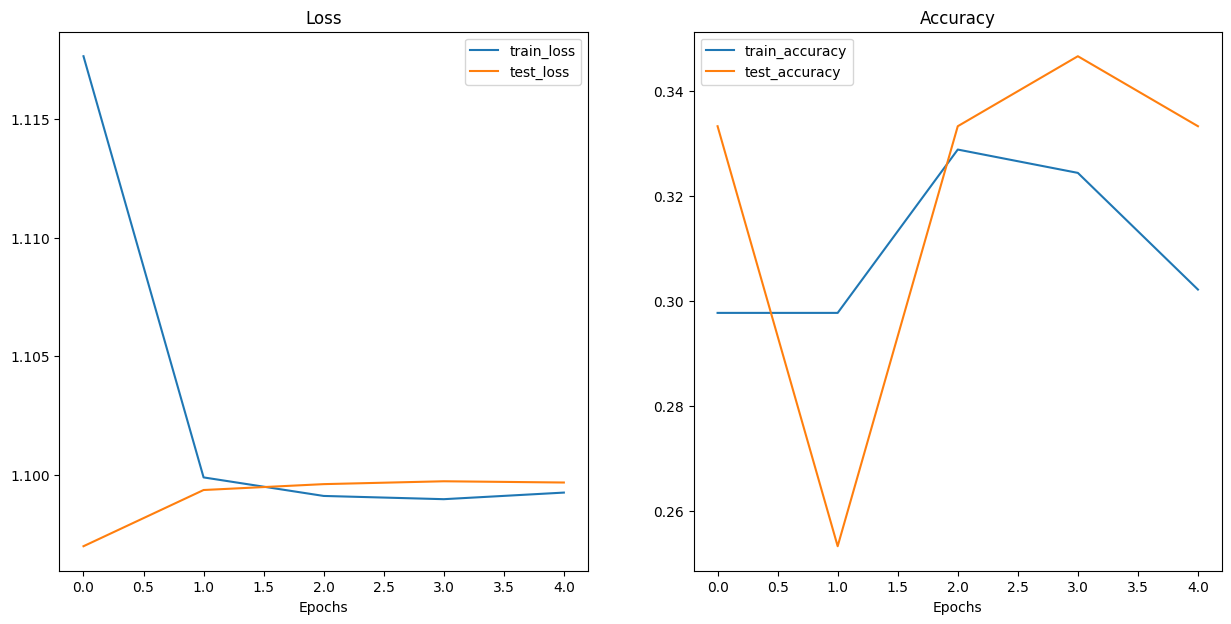

In [119]:
plot_loss_curves(model_0_results)

Woah.

Looks like things are all over the place...

But we kind of knew that because our model's print out results during training didn't show much promise.

## 4. Model 1: TinyVGG with Data Augmentation
This time, let's load in the data and use data augmentation to see if it improves our results in anyway.

First, we'll compose a training transform to include transforms.TrivialAugmentWide() as well as resize and turn our images into tensors.

We'll do the same for a testing transform except without the data augmentation.



### 4.1 Create transform with data augmentation

In [120]:
# Create training transform with TrivialAugment
train_transform_trivial_augment = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

# Create testing transform (no data augmentation)
test_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

 ### 4.2 Create train and test Dataset's and DataLoader's

In [121]:
# Turn image folders into Datasets
train_data_augmented = datasets.ImageFolder(train_dir, transform=train_transform_trivial_augment)
test_data_simple = datasets.ImageFolder(test_dir, transform=test_transform)

train_data_augmented, test_data_simple

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
            ))

In [122]:
# Turn Datasets into DataLoader's
import os
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

torch.manual_seed(42)
train_dataloader_augmented = DataLoader(train_data_augmented,
                                        batch_size=BATCH_SIZE,
                                        shuffle=True,
                                        num_workers=NUM_WORKERS)

test_dataloader_simple = DataLoader(test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                    num_workers=NUM_WORKERS)

train_dataloader_augmented, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7c67dbaf4e50>,
 <torch.utils.data.dataloader.DataLoader at 0x7c67db96f910>)

### 4.3 Construct and train Model 1

In [123]:
# Create model_1 and send it to the target device
torch.manual_seed(42)
model_1 = TinyVGG(
    input_shape=3,
    hidden_units=10,
    output_shape=len(train_data_augmented.classes)).to(device)
model_1

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

### 4.4 Training time

In [124]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 5

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_1
model_1_results = train(model=model_1,
                        train_dataloader=train_dataloader_augmented,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1074 | train_acc: 0.2500 | test_loss: 1.1059 | test_acc: 0.2604
Epoch: 2 | train_loss: 1.0790 | train_acc: 0.4258 | test_loss: 1.1384 | test_acc: 0.2604
Epoch: 3 | train_loss: 1.0802 | train_acc: 0.4258 | test_loss: 1.1696 | test_acc: 0.2604
Epoch: 4 | train_loss: 1.1286 | train_acc: 0.3047 | test_loss: 1.1620 | test_acc: 0.2604
Epoch: 5 | train_loss: 1.0885 | train_acc: 0.4258 | test_loss: 1.1477 | test_acc: 0.2604
Total training time: 5.200 seconds


It doesn't look like our model performed very well again.

Let's check out its loss curves.


### 4.5 Plot the loss curves of Model 1

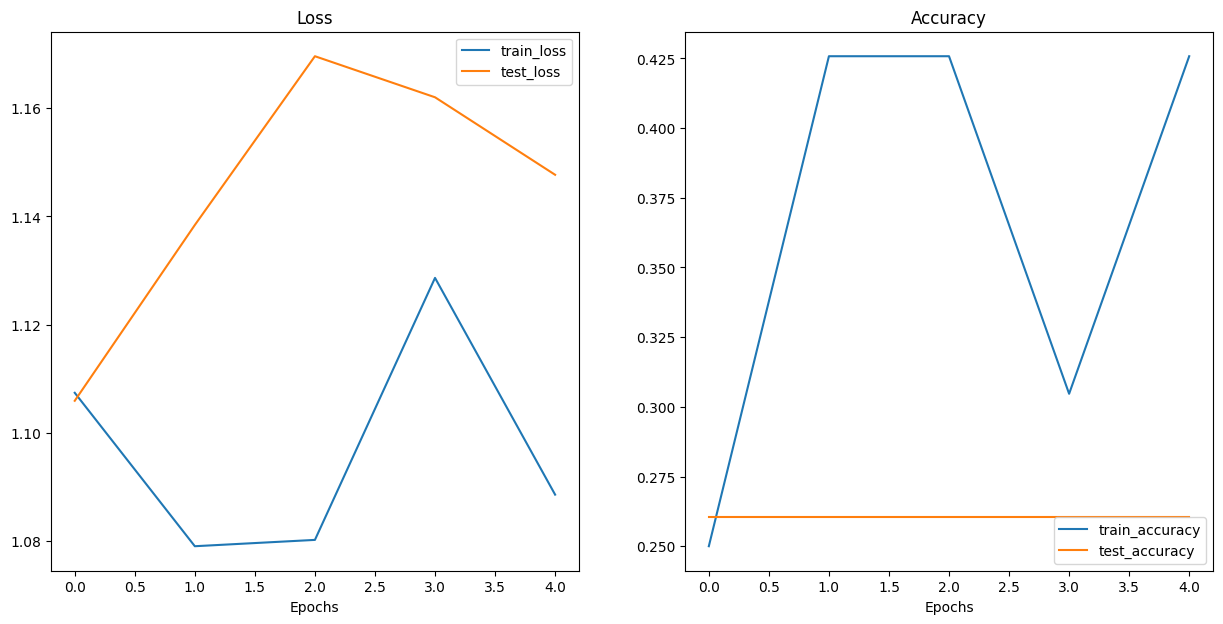

In [125]:
plot_loss_curves(model_1_results)

### 4.6 Compare model results

In [126]:
import pandas as pd
model_0_df = pd.DataFrame(model_0_results)
model_1_df = pd.DataFrame(model_1_results)
model_0_df

,train_loss,train_acc,test_loss,test_acc
0,1.117658,0.297778,1.096974,0.333333
1,1.099879,0.297778,1.099347,0.253333
2,1.099096,0.328889,1.099595,0.333333
3,1.098959,0.324444,1.099716,0.346667
4,1.099238,0.302222,1.099663,0.333333


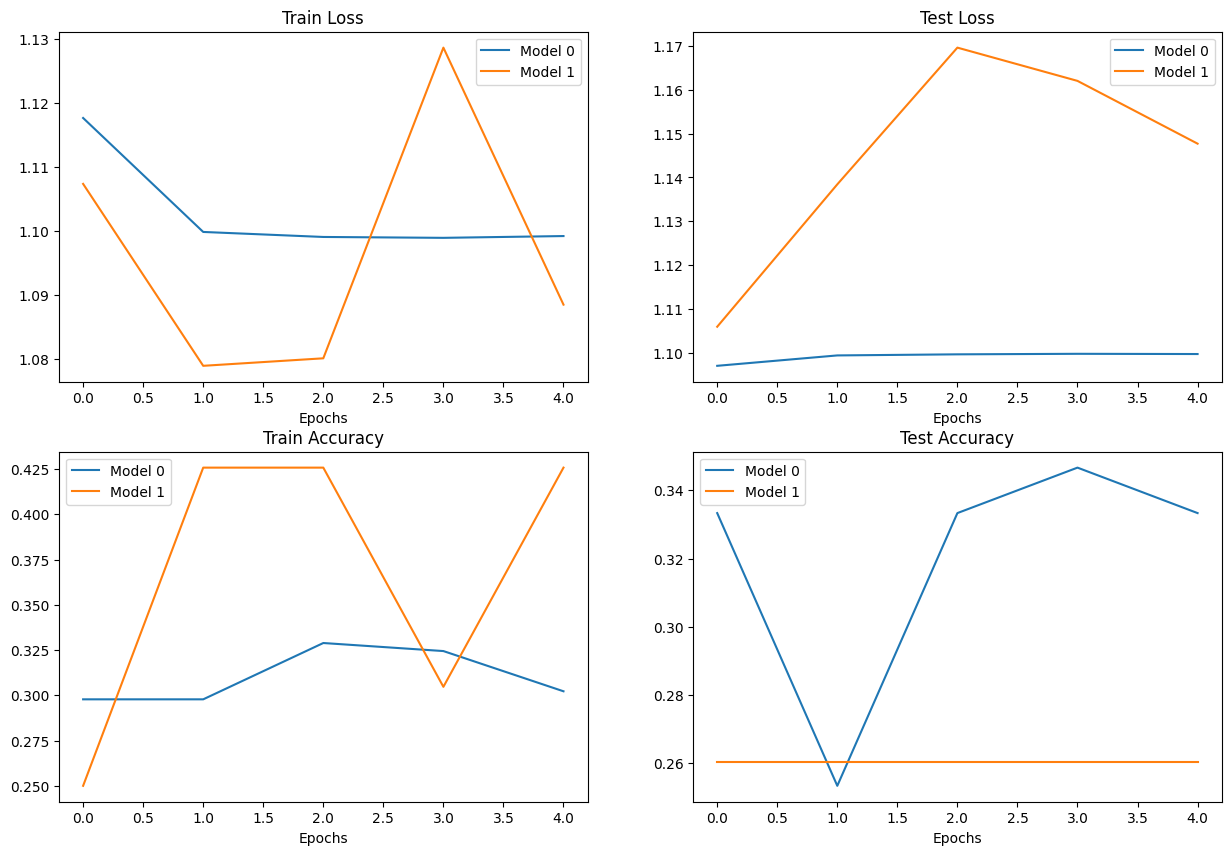

In [127]:
# Setup a plot
plt.figure(figsize=(15, 10))

# Get number of epochs
epochs = range(len(model_0_df))

# Plot train loss
plt.subplot(2, 2, 1)
plt.plot(epochs, model_0_df["train_loss"], label="Model 0")
plt.plot(epochs, model_1_df["train_loss"], label="Model 1")
plt.title("Train Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot test loss
plt.subplot(2, 2, 2)
plt.plot(epochs, model_0_df["test_loss"], label="Model 0")
plt.plot(epochs, model_1_df["test_loss"], label="Model 1")
plt.title("Test Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot train accuracy
plt.subplot(2, 2, 3)
plt.plot(epochs, model_0_df["train_acc"], label="Model 0")
plt.plot(epochs, model_1_df["train_acc"], label="Model 1")
plt.title("Train Accuracy")
plt.xlabel("Epochs")
plt.legend()

# Plot test accuracy
plt.subplot(2, 2, 4)
plt.plot(epochs, model_0_df["test_acc"], label="Model 0")
plt.plot(epochs, model_1_df["test_acc"], label="Model 1")
plt.title("Test Accuracy")
plt.xlabel("Epochs")
plt.legend();

## 5. PyTorch Transfer Learning Model 3


Till, now we have been traning only with the 10% of the data. And with this little amount of data it does not show the good result.

Let's check apply the transfer learning and see the magic.

**What is transfer learning?**

*Transfer learning allows us to take the patterns (also called weights) another model has learned from another problem and use them for our own problem.*


### 5.1 Getting a pretrained model

we've been building PyTorch neural networks from scratch.

And while that's a good skill to have, our models haven't been performing as well as we'd like.

That's where transfer learning comes in.

The whole idea of transfer learning is to take an already well-performing model on a problem-space similar to yours and then customise it to your use case.

Since we're working on a computer vision problem (image classification with FoodVision Mini), we can find pretrained classification models in `torchvision.models`.
https://docs.pytorch.org/vision/0.21/models.html

Based on my previous experience i am going to pick the pretrained Model `EfficientNet`

### 5.2 Creating a transform for `torchvision.models`


**What is EfficientNet?**

EfficientNet is a type of deep learning model designed for image classification. It became popular after performing extremely well on the ImageNet benchmark — a large-scale dataset used to test how good models are at recognizing images.

ImageNet models like ResNet and Inception were powerful but also very large and slow. EfficientNet changed that by offering better accuracy with fewer parameters (i.e., it's both smart and efficient).



#### 5.2.1 Setting up a pretrained model

The pretrained model we're going to be using is torchvision.models.efficientnet_b0().

The architecture is from the paper EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks.

![](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/06-effnet-b0-feature-extractor.png)

In [128]:
import torchvision

weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # .DEFAULT = best available weights
model_3 = torchvision.models.efficientnet_b0(weights=weights).to(device)

# model_3

### 5.3 Create Datasets and DataLoaders

In [129]:
# Get the transforms used to create our pretrained weights
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [130]:
# Use ImageFolder to create dataset(s)
train_data_pretrained = datasets.ImageFolder(root=train_dir, # target folder of images
                                  transform=auto_transforms, # transforms to perform on data (images)
                                  target_transform=None) # transforms to perform on labels (if necessary)

test_data_pretrained = datasets.ImageFolder(root=test_dir,
                                 transform=auto_transforms)

#Now Create the Dataloaders
train_dataloader_pretrained = DataLoader(train_data_pretrained,
                                        batch_size=BATCH_SIZE,
                                        shuffle=True,
                                        num_workers=NUM_WORKERS)

test_dataloader_pretrained = DataLoader(test_data_pretrained,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                    num_workers=NUM_WORKERS)


### 7.3 Getting a summary of our model with torchinfo.summary()

In [131]:
# Print a summary using torchinfo
summary(model=model_3,
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

Woah!

Now that's a big model!

From the output of the summary, we can see all of the various input and output shape changes as our image data goes through the model.

And there are a whole bunch more total parameters (pretrained weights) to recognize different patterns in our data.

For reference, our model from previous sections, TinyVGG had 8,083 parameters vs. 5,288,548 parameters for efficientnet_b0, an increase of ~654x!



### 5.4 Freezing the base model and changing the output layer to suit our needs

The process of transfer learning usually goes: freeze some base layers of a pretrained model (typically the features section) and then adjust the output layers (also called head/classifier layers) to suit your needs.

**We can freeze all of the layers/parameters in the features section by setting the attribute `requires_grad=False`.**

In [132]:
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for param in model_3.features.parameters():
    param.requires_grad = False

In [133]:
# Print a summary using torchinfo
summary(model=model_3,
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

Feature extractor layers frozen!

Let's now adjust the output layer or the classifier portion of our pretrained model to our needs.

Right now our pretrained model has out_features=1000 because there are 1000 classes in ImageNet.

However, we don't have 1000 classes, we only have three, pizza, steak and sushi.

We can change the classifier portion of our model by creating a new series of layers.

The current classifier consists of:

```python
(classifier): Sequential(
    (0): Dropout(p=0.2, inplace=True)
    (1): Linear(in_features=1280, out_features=1000, bias=True)


```


In [134]:
# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
model_3.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1280,
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)

In [135]:
# # Print a summary using torchinfo
summary(model=model_3,
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

### 5.5 Train model

Now we've got a pretrained model that's semi-frozen and has a customised classifier, how about we see transfer learning in action?

To begin training, let's create a loss function and an optimizer.

Because we're still working with multi-class classification, we'll use nn.`CrossEntropyLoss()` for the loss function.

And we'll stick with `torch.optim.Adam()` as our optimizer with `lr=0.001`.



In [136]:
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

NUM_EPOCHS = 5



# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_3.parameters(), lr=0.001)



# Setup training and save the results
model_3_results = train(model=model_3,
                       train_dataloader=train_dataloader_pretrained,
                       test_dataloader=test_dataloader_pretrained,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=NUM_EPOCHS,
                       )

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0924 | train_acc: 0.3984 | test_loss: 0.9133 | test_acc: 0.5398
Epoch: 2 | train_loss: 0.8718 | train_acc: 0.7773 | test_loss: 0.7912 | test_acc: 0.8153
Epoch: 3 | train_loss: 0.7648 | train_acc: 0.7930 | test_loss: 0.7464 | test_acc: 0.8561
Epoch: 4 | train_loss: 0.7109 | train_acc: 0.7539 | test_loss: 0.6374 | test_acc: 0.8655
Epoch: 5 | train_loss: 0.6255 | train_acc: 0.7852 | test_loss: 0.6261 | test_acc: 0.8561
[INFO] Total training time: 14.601 seconds


Wow!

Our model trained quite fast

And it looks like it smashed our previous model results out of the park!

With an efficientnet_b0 backbone, our model achieves almost 92%+ accuracy on the test dataset, almost double what we were able to achieve with TinyVGG.

Not bad for a model we downloaded with a few lines of code.

### 5.6. Evaluate model by plotting loss curves

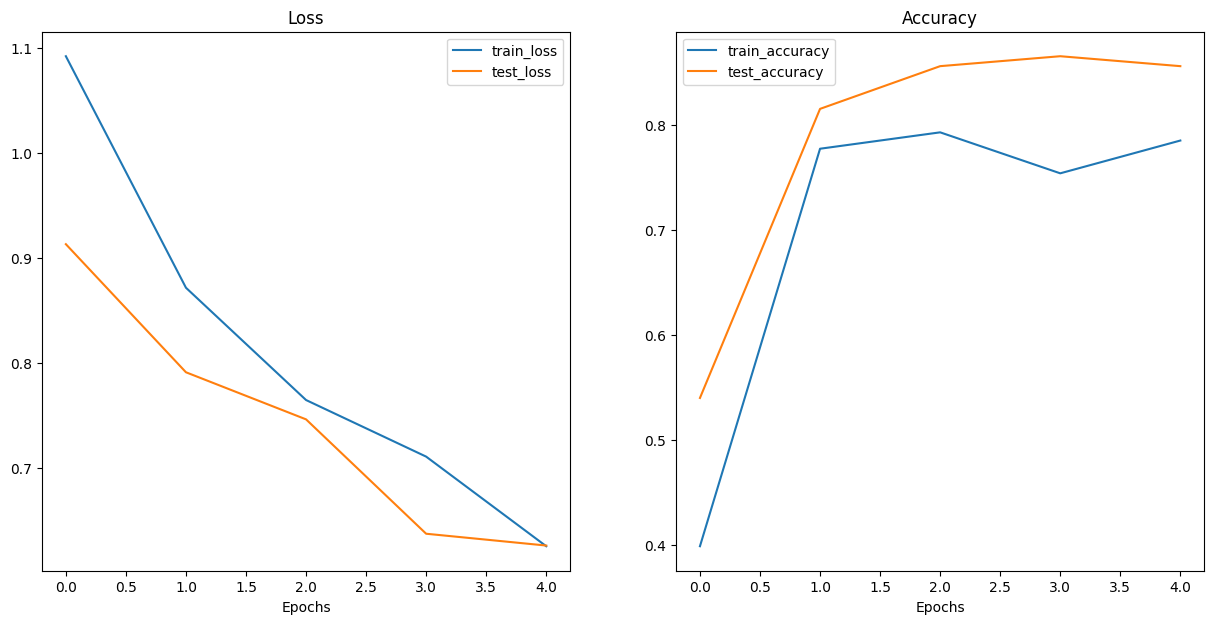

In [137]:
plot_loss_curves(model_3_results)

Those are some excellent looking loss curves!

It looks like the loss for both datasets (train and test) is heading in the right direction.

The same with the accuracy values, trending upwards.

That goes to show the power of transfer learning. Using a pretrained model often leads to pretty good results with a small amount of data in less time.

I wonder what would happen if you tried to train the model for longer? Or if we added more data?



## 6. PyTorch Transfer Learning using ViT

### 6.1 Create Datasets and DataLoaders

In [138]:
# 1. Get pretrained weights for ViT-Base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT # "DEFAULT" means best available

# 2. Setup a ViT model instance with pretrained weights
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

# 3. Freeze the base parameters
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False

# 4. Change the classifier head (set the seeds to ensure same initialization with linear head)
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)
# pretrained_vit

In [139]:
# # Print a summary using torchinfo
summary(model=pretrained_vit,
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 3]              768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

### 6.2 Preparing data for the pretrained ViT model

In [140]:
# Get automatic transforms from pretrained ViT weights
pretrained_vit_transforms = pretrained_vit_weights.transforms()
print(pretrained_vit_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [141]:
# Use ImageFolder to create dataset(s)
train_data_vit = datasets.ImageFolder(root=train_dir, # target folder of images
                                  transform=pretrained_vit_transforms, # transforms to perform on data (images)
                                  target_transform=None) # transforms to perform on labels (if necessary)

test_data_vit = datasets.ImageFolder(root=test_dir,
                                 transform=pretrained_vit_transforms)

#Now Create the Dataloaders
train_dataloader_pretrained_vit = DataLoader(train_data_vit,
                                        batch_size=BATCH_SIZE,
                                        shuffle=True,
                                        num_workers=NUM_WORKERS)

test_dataloader_pretrained_vit = DataLoader(test_data_vit,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                    num_workers=NUM_WORKERS)

In [142]:
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

NUM_EPOCHS = 5


# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(), lr=0.001)



# Setup training and save the results
model_4_results = train(model=pretrained_vit,
                       train_dataloader=train_dataloader_pretrained_vit,
                       test_dataloader=test_dataloader_pretrained_vit,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=NUM_EPOCHS,
                       )

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7685 | train_acc: 0.7656 | test_loss: 0.4828 | test_acc: 0.8977
Epoch: 2 | train_loss: 0.3356 | train_acc: 0.9453 | test_loss: 0.2767 | test_acc: 0.9593
Epoch: 3 | train_loss: 0.1970 | train_acc: 0.9570 | test_loss: 0.2203 | test_acc: 0.9384
Epoch: 4 | train_loss: 0.1495 | train_acc: 0.9609 | test_loss: 0.1961 | test_acc: 0.9384
Epoch: 5 | train_loss: 0.1204 | train_acc: 0.9688 | test_loss: 0.1888 | test_acc: 0.9384
[INFO] Total training time: 27.595 seconds


### 6.3 plot_loss_curves(model_4_results)

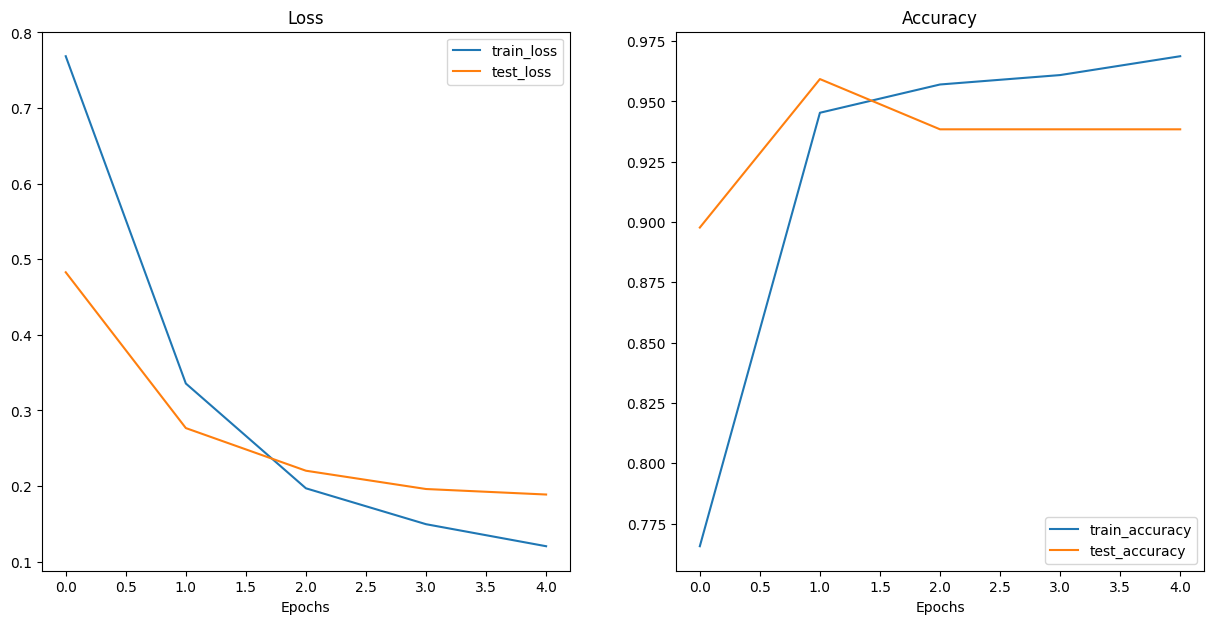

In [143]:
plot_loss_curves(model_4_results)

## Training the model for 20% of the Data

So far, we've been training the model for only 10% of data (And with this little amount of data, training from scratch performed worse and pretrained model took little bit time and performed the best), Let's train it by 20% of data and will see the result.


### 7.1 Training From Scratch using 20% of data.

#### 7.1.1 Download the 20% data

In [144]:
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi_20_percent"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi_20_percent.zip", "wb") as f:
        request = requests.get("https://github.com/krrish9973/pytorch-deep-learning/raw/refs/heads/main/data/pizza_steak_sushi_20_percent.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi_20_percent.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...")
        zip_ref.extractall(image_path)

data/pizza_steak_sushi_20_percent directory exists.


### 7.2 Create `Datasets` and `DataLoader`'s

In [145]:
# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi_20_percent/train'),
 PosixPath('data/pizza_steak_sushi_20_percent/test'))

In [146]:
# Use ImageFolder to create dataset(s) will be using the same transforms
from torchvision import datasets
train_data20 = datasets.ImageFolder(root=train_dir, # target folder of images
                                  transform=data_transform, # transforms to perform on data (images)
                                  target_transform=None) # transforms to perform on labels (if necessary)

test_data20 = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)

print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 225
    Root location: data/pizza_steak_sushi/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 75
    Root location: data/pizza_steak_sushi/test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )


In [147]:
# Turn train and test Datasets into DataLoaders
from torch.utils.data import DataLoader
train_dataloader20 = DataLoader(dataset=train_data20,
                              batch_size=32, # how many samples per batch?
                              num_workers=1, # how many subprocesses to use for data loading? (higher = more)
                              shuffle=True) # shuffle the data?

test_dataloader20 = DataLoader(dataset=test_data20,
                             batch_size=32,
                             num_workers=1,
                             shuffle=False) # don't usually need to shuffle testing data

train_dataloader20, test_dataloader20

(<torch.utils.data.dataloader.DataLoader at 0x7c67dbba4e50>,
 <torch.utils.data.dataloader.DataLoader at 0x7c67dbf5f910>)

### 7.3 Training

we'll be using the same TinyVGG model for training from scratch

In [148]:
torch.manual_seed(42)
model_5 = TinyVGG(input_shape=3, # number of color channels (3 for RGB)
                  hidden_units=10,
                  output_shape=len(train_data.classes)).to(device)
model_5

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

In [149]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 5

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_5.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_1
model_5_results = train(model=model_5,
                        train_dataloader=train_dataloader20,
                        test_dataloader=test_dataloader20,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1060 | train_acc: 0.3042 | test_loss: 1.1061 | test_acc: 0.2875
Epoch: 2 | train_loss: 1.1000 | train_acc: 0.3521 | test_loss: 1.0993 | test_acc: 0.3063
Epoch: 3 | train_loss: 1.0980 | train_acc: 0.3542 | test_loss: 1.0882 | test_acc: 0.4903
Epoch: 4 | train_loss: 1.0798 | train_acc: 0.4896 | test_loss: 1.0625 | test_acc: 0.4903
Epoch: 5 | train_loss: 1.0157 | train_acc: 0.5771 | test_loss: 0.9470 | test_acc: 0.5909
Total training time: 9.667 seconds


### 7.4 plot_loss_curves(model_5_results)

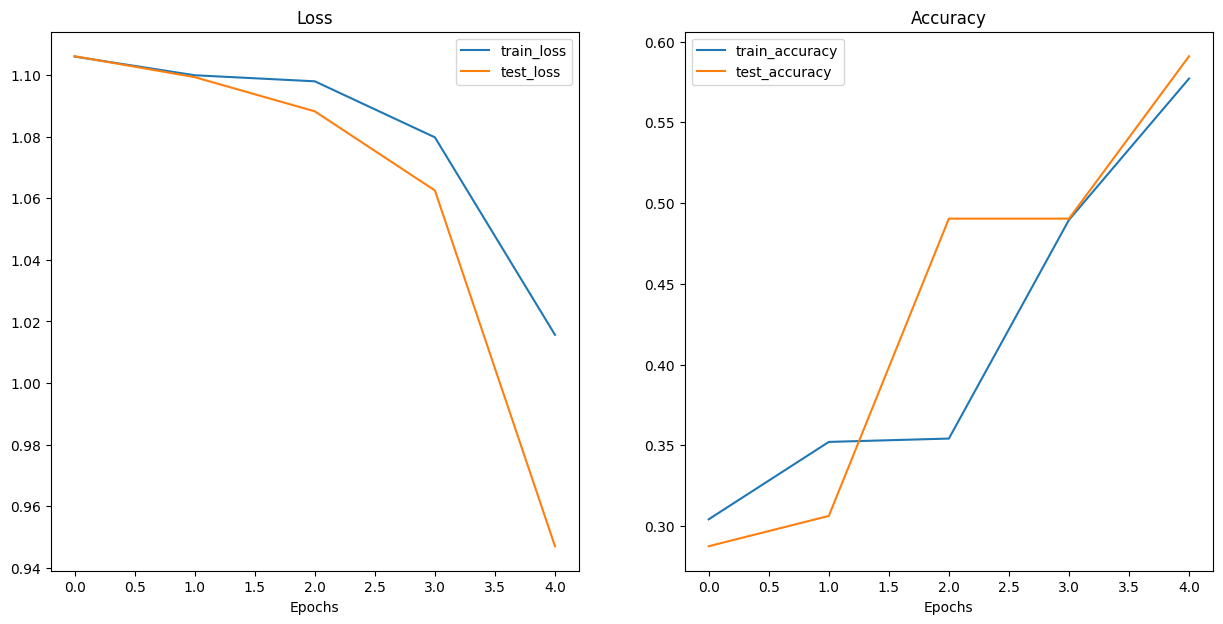

In [150]:
plot_loss_curves(model_5_results)

### 7.5 Conclusion for Training From Scratch when dataset Increased

Hurray !!! :)


==> When dataset is increased to 20% , it is performing good. This also means that it could perform good if we increase the training datasets, increase number of epochs, Data Augmentations etc..

## 8. Training Using the Pretrained Model EfficentNet using 20% data

### 8.1 Create `datasets` and `DataLoader`'s

In [151]:
# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# 1. Get pretrained weights for EfficientNet_B0
pretrained_effnet_weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # "DEFAULT" means best available

# 2. Setup a effnet model instance with pretrained weights
pretrained_effnet_20 = torchvision.models.efficientnet_b0(weights=pretrained_effnet_weights).to(device)

# 3. Freeze the base parameters
for parameter in pretrained_effnet_20.parameters():
    parameter.requires_grad = False

# Recreate the classifier layer and seed it to the target device
pretrained_effnet_20.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1280,
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)

In [152]:
# # Print a summary using torchinfo (uncomment for actual output)
summary(model=pretrained_effnet_20,
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

In [153]:
# Get the transforms used to create our pretrained weights
auto_transforms = pretrained_effnet_weights.transforms()
# auto_transforms

BATCH_SIZE = 32

# Use ImageFolder to create dataset(s)
train_data_pretrained20 = datasets.ImageFolder(root=train_dir, # target folder of images
                                  transform=auto_transforms, # transforms to perform on data (images)
                                  target_transform=None) # transforms to perform on labels (if necessary)

test_data_pretrained20 = datasets.ImageFolder(root=test_dir,
                                 transform=auto_transforms)

#Now Create the Dataloaders
train_dataloader_pretrained20 = DataLoader(train_data_pretrained20,
                                        batch_size=BATCH_SIZE,
                                        shuffle=True,
                                        num_workers=NUM_WORKERS)

test_dataloader_pretrained20 = DataLoader(test_data_pretrained20,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                    num_workers=NUM_WORKERS)

### 8.2 Training

In [154]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 5

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=pretrained_effnet_20.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_1
model_6_results = train(model=pretrained_effnet_20,
                        train_dataloader=train_dataloader_pretrained20,
                        test_dataloader=test_dataloader_pretrained20,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9591 | train_acc: 0.5833 | test_loss: 0.6702 | test_acc: 0.9006
Epoch: 2 | train_loss: 0.6949 | train_acc: 0.8292 | test_loss: 0.5475 | test_acc: 0.9131
Epoch: 3 | train_loss: 0.5899 | train_acc: 0.8104 | test_loss: 0.4655 | test_acc: 0.9102
Epoch: 4 | train_loss: 0.4500 | train_acc: 0.9021 | test_loss: 0.4151 | test_acc: 0.9159
Epoch: 5 | train_loss: 0.4518 | train_acc: 0.8812 | test_loss: 0.3961 | test_acc: 0.8983
Total training time: 9.363 seconds


### 8.3 Plot Loss Curve

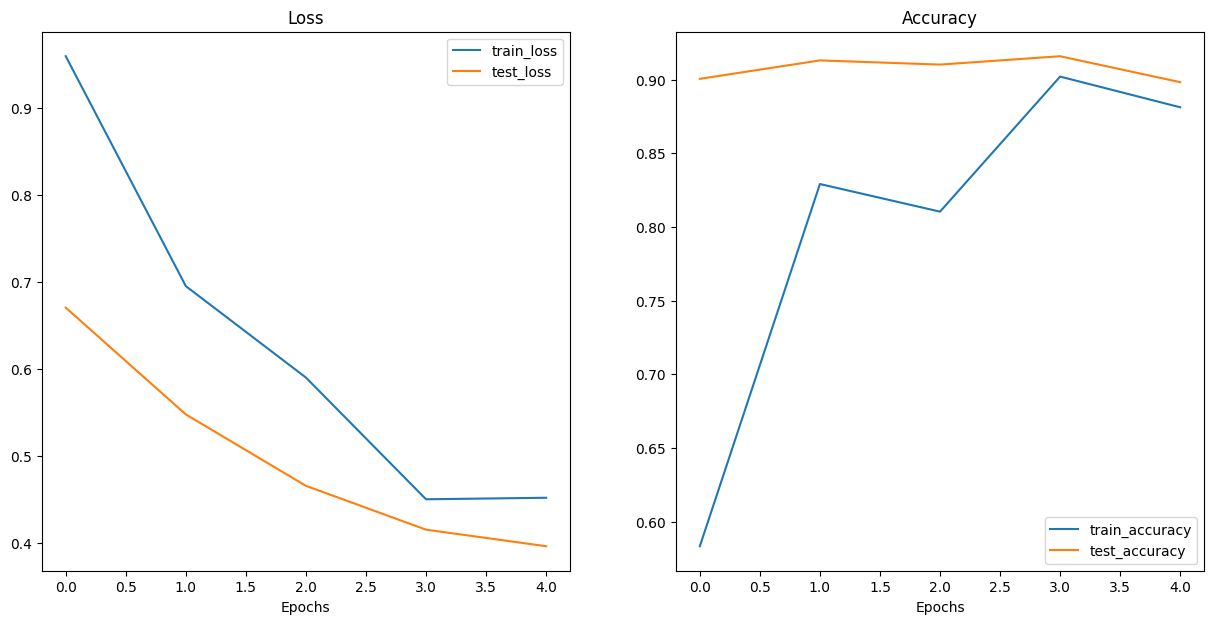

In [155]:
plot_loss_curves(model_6_results)

### 7.5 Conclusion for Training From Scratch when dataset Increased for Pretrained Model EfficientNet

Hurray !!! :)

==> When dataset is increased to 20% , it is performing good, well accuracy looks approximately same but graph looks better than on 10% data. This also means that it could perform good if we increase the training datasets, increase number of epochs, Data Augmentations etc..

## 9. Training Using the Pretrained Transformer Model ViT using 20% data

### 8.1 Create `datasets` and `DataLoader`'s

In [156]:
# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# 1. Get pretrained weights for EfficientNet_B0
pretrained_vit_weights20 = torchvision.models.ViT_B_16_Weights.DEFAULT # "DEFAULT" means best available

# 2. Setup a effnet model instance with pretrained weights
pretrained_vit_20 = torchvision.models.vit_b_16(weights=pretrained_vit_weights20).to(device)

# 3. Freeze the base parameters
for parameter in pretrained_vit_20.parameters():
    parameter.requires_grad = False

# Recreate the classifier layer and seed it to the target device
pretrained_vit_20.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)

In [157]:
# # Print a summary using torchinfo (uncomment for actual output)
summary(model=pretrained_vit_20,
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 3]              768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

In [158]:
# Get the transforms used to create our pretrained weights
vit_transforms = pretrained_vit_weights20.transforms()
# auto_transforms

BATCH_SIZE = 32

# Use ImageFolder to create dataset(s)
train_data_pretrained_vit20 = datasets.ImageFolder(root=train_dir, # target folder of images
                                  transform=vit_transforms, # transforms to perform on data (images)
                                  target_transform=None) # transforms to perform on labels (if necessary)

test_data_pretrained_vit20 = datasets.ImageFolder(root=test_dir,
                                 transform=vit_transforms)

#Now Create the Dataloaders
train_dataloader_pretrained_vit20 = DataLoader(train_data_pretrained_vit20,
                                        batch_size=BATCH_SIZE,
                                        shuffle=True,
                                        num_workers=NUM_WORKERS)

test_dataloader_pretrained_vit20 = DataLoader(test_data_pretrained_vit20,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                    num_workers=NUM_WORKERS)
len(train_dataloader_pretrained_vit20), len(test_dataloader_pretrained_vit20)

(15, 5)

### 8.2 Training

In [159]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 5

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=pretrained_vit_20.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_1
model_7_results = train(model=pretrained_vit_20,
                        train_dataloader=train_dataloader_pretrained_vit20,
                        test_dataloader=test_dataloader_pretrained_vit20,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.6470 | train_acc: 0.8208 | test_loss: 0.2180 | test_acc: 0.9625
Epoch: 2 | train_loss: 0.2492 | train_acc: 0.9208 | test_loss: 0.1354 | test_acc: 0.9938
Epoch: 3 | train_loss: 0.1707 | train_acc: 0.9667 | test_loss: 0.1040 | test_acc: 0.9938
Epoch: 4 | train_loss: 0.1253 | train_acc: 0.9688 | test_loss: 0.0882 | test_acc: 0.9875
Epoch: 5 | train_loss: 0.1121 | train_acc: 0.9708 | test_loss: 0.0778 | test_acc: 0.9938
Total training time: 17.255 seconds


### 8.3 Plot Loss Curve

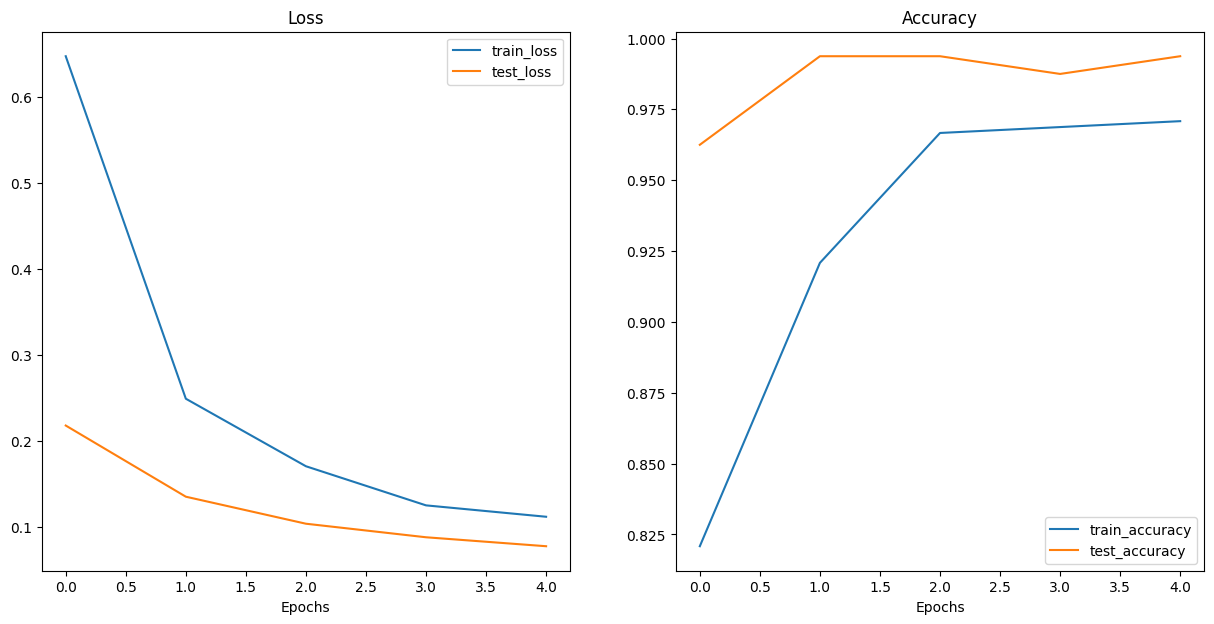

In [160]:
plot_loss_curves(model_7_results)

### 8.4 COnclusion

Woah !! :)
A Pretrained Model of Vision Transformer ViT is the winner with 98+ % accuracy only on 20% of data.

## 9. Conclusion : Which Model to choose?

Choosing Models depends on various factors Speed, Accuracy Size etc... If size is too big, it might be not appropriate for Mobile devices. But it depends on individual needs.

Pretrained Model wins the race. Let's check the size of the file.

### 9.1 Saving the Feature Extractor EffNet

In [161]:
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "Effnet_feature_extractor_model.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=pretrained_effnet_20.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: models/Effnet_feature_extractor_model.pth


### 9.2 Saving the Feature Extractor ViT

In [162]:
from pathlib import Path

# 2. Create model save path
MODEL_NAME = "Vit_feature_extractor_model.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=pretrained_vit_20.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: models/Vit_feature_extractor_model.pth


### 9.3 Check the Size of Saved Model

In [163]:
from pathlib import Path

# Get the model size in bytes then convert to megabytes
pretrained_effnet_model_size = Path("models/Effnet_feature_extractor_model.pth").stat().st_size // (1024*1024) # division converts bytes to megabytes (roughly)
pretrained_vit_model_size = Path("models/Vit_feature_extractor_model.pth").stat().st_size // (1024*1024)
print(f"Pretrained Effnet feature extractor model size: {pretrained_effnet_model_size} MB")
print(f"Pretrained ViT feature extractor model size: {pretrained_vit_model_size} MB")

Pretrained Effnet feature extractor model size: 15 MB
Pretrained ViT feature extractor model size: 327 MB


In [164]:
327/15

21.8

###  9.4 Which model performed Better?

ViT model is approximately 22 times the size of Effnet. So, If it worth it  going to ViT Model depends on individuals Requirements. Also, model could be further improved by increasing the datasets as right now we are using only 20% of data.

For now due to size, i am going with Effnet and going to deploy this on `Hugging Face` Space Using Gradio

## 10 Deployed Gradio app structure

```python
demos/
└── foodvision_mini/
    ├── pretrained_effnet_20.pth
    ├── app.py
    ├── examples/
    │   ├── example_1.jpg
    │   ├── example_2.jpg
    │   └── example_3.jpg
    ├── model.py
    └── requirements.txt
```

### 10.1 Creating a demos folder to store our FoodVision Mini app files

In [165]:
import shutil
from pathlib import Path

# Create FoodVision mini demo path
foodvision_mini_demo_path = Path("demos/foodvision_mini/")

# Remove files that might already exist there and create new directory
if foodvision_mini_demo_path.exists():
    shutil.rmtree(foodvision_mini_demo_path)
# If the file doesn't exist, create it anyway
foodvision_mini_demo_path.mkdir(parents=True,
                                exist_ok=True)

# Check what's in the folder
!ls demos/foodvision_mini/

### 10.2 Creating a folder of example images to use with our FoodVision Mini demo

In [166]:
import shutil
from pathlib import Path

# 1. Create an examples directory
foodvision_mini_examples_path = foodvision_mini_demo_path / "examples"
foodvision_mini_examples_path.mkdir(parents=True, exist_ok=True)

# 2. Collect three random test dataset image paths
foodvision_mini_examples = [Path('data/pizza_steak_sushi_20_percent/test/sushi/592799.jpg'),
                            Path('data/pizza_steak_sushi_20_percent/test/steak/3622237.jpg'),
                            Path('data/pizza_steak_sushi_20_percent/test/pizza/2582289.jpg')]

# 3. Copy the three random images to the examples directory
for example in foodvision_mini_examples:
    destination = foodvision_mini_examples_path / example.name
    print(f"[INFO] Copying {example} to {destination}")
    shutil.copy2(src=example, dst=destination)

[INFO] Copying data/pizza_steak_sushi_20_percent/test/sushi/592799.jpg to demos/foodvision_mini/examples/592799.jpg
[INFO] Copying data/pizza_steak_sushi_20_percent/test/steak/3622237.jpg to demos/foodvision_mini/examples/3622237.jpg
[INFO] Copying data/pizza_steak_sushi_20_percent/test/pizza/2582289.jpg to demos/foodvision_mini/examples/2582289.jpg


In [167]:
import os

# Get example filepaths in a list of lists
example_list = [["examples/" + example] for example in os.listdir(foodvision_mini_examples_path)]
example_list

[['examples/3622237.jpg'], ['examples/2582289.jpg'], ['examples/592799.jpg']]

### 10.3 Moving our trained EffNetB0 model to our FoodVision Mini demo directory

In [168]:
import shutil

# Create a source path for our target model
effnetb0_foodvision_mini_model_path = "models/Effnet_feature_extractor_model.pth"

# Create a destination path for our target model
effnetb0_foodvision_mini_model_destination = foodvision_mini_demo_path / effnetb0_foodvision_mini_model_path.split("/")[1]

# Try to move the file
try:
    print(f"[INFO] Attempting to move {effnetb0_foodvision_mini_model_path} to {effnetb0_foodvision_mini_model_destination}")

    # Move the model
    shutil.move(src=effnetb0_foodvision_mini_model_path,
                dst=effnetb0_foodvision_mini_model_destination)

    print(f"[INFO] Model move complete.")

# If the model has already been moved, check if it exists
except:
    print(f"[INFO] No model found at {effnetb0_foodvision_mini_model_path}, perhaps its already been moved?")
    print(f"[INFO] Model exists at {effnetb0_foodvision_mini_model_destination}: {effnetb0_foodvision_mini_model_destination.exists()}")

[INFO] Attempting to move models/Effnet_feature_extractor_model.pth to demos/foodvision_mini/Effnet_feature_extractor_model.pth
[INFO] Model move complete.


### 10.4 Turning our EffNetB0 model into a Python script (`model.py`)

In [169]:
%%writefile demos/foodvision_mini/model.py
import torch
import torchvision

from torch import nn


def create_effnetb0_model(num_classes:int=3,
                          seed:int=42):
    """Creates an EfficientNetB0 feature extractor model and transforms.

    Args:
        num_classes (int, optional): number of classes in the classifier head.
            Defaults to 3.
        seed (int, optional): random seed value. Defaults to 42.

    Returns:
        model (torch.nn.Module): EffNetB0 feature extractor model.
        transforms (torchvision.transforms): EffNetB0 image transforms.
    """
    # Create EffNetB0 pretrained weights, transforms and model
    weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.efficientnet_b0(weights=weights)

    # Freeze all layers in base model
    for param in model.parameters():
        param.requires_grad = False

    # Change classifier head with random seed for reproducibility
    torch.manual_seed(seed)
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1280, out_features=num_classes),
    )

    return model, transforms

Writing demos/foodvision_mini/model.py


### 10.5 Turning our FoodVision Mini Gradio app into a Python script (app.py)

In [170]:
%%writefile demos/foodvision_mini/app.py
### 1. Imports and class names setup ###
import gradio as gr
import os
import torch

from model import create_effnetb0_model
from timeit import default_timer as timer
from typing import Tuple, Dict

# Setup class names
class_names = ["pizza", "steak", "sushi"]

### 2. Model and transforms preparation ###

# Create EffNetB0 model
effnetb0, effnetb0_transforms = create_effnetb0_model(
    num_classes=3, # len(class_names) would also work
)

# Load saved weights
effnetb0.load_state_dict(
    torch.load(
        f="Effnet_feature_extractor_model.pth",
        map_location=torch.device("cpu"),  # load to CPU
    )
)

### 3. Predict function ###

# Create predict function
def predict(img) -> Tuple[Dict, float]:
    """Transforms and performs a prediction on img and returns prediction and time taken.
    """
    # Start the timer
    start_time = timer()

    # Transform the target image and add a batch dimension
    img = effnetb0_transforms(img).unsqueeze(0)

    # Put model into evaluation mode and turn on inference mode
    effnetb0.eval()
    with torch.inference_mode():
        # Pass the transformed image through the model and turn the prediction logits into prediction probabilities
        pred_probs = torch.softmax(effnetb0(img), dim=1)

    # Create a prediction label and prediction probability dictionary for each prediction class (this is the required format for Gradio's output parameter)
    pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

    # Calculate the prediction time
    pred_time = round(timer() - start_time, 5)

    # Return the prediction dictionary and prediction time
    return pred_labels_and_probs, pred_time

### 4. Gradio app ###

# Create title, description and article strings
title = "FoodVision Mini 🍕🥩🍣"
description = "An EfficientNetB0 feature extractor computer vision model to classify images of food as pizza, steak or sushi."
article = "Created on: 27.06.2025 : For Portfolio Development Fun Project"

# Create examples list from "examples/" directory
example_list = [["examples/" + example] for example in os.listdir("examples")]

# Create the Gradio demo
demo = gr.Interface(fn=predict, # mapping function from input to output
                    inputs=gr.Image(type="pil"), # what are the inputs?
                    outputs=[gr.Label(num_top_classes=3, label="Predictions"), # what are the outputs?
                             gr.Number(label="Prediction time (s)")], # our fn has two outputs, therefore we have two outputs
                    # Create examples list from "examples/" directory
                    examples=example_list,
                    title=title,
                    description=description,
                    article=article)

# Launch the demo!
demo.launch()

Writing demos/foodvision_mini/app.py


### 10.6 Creating a requirements file for FoodVision Mini (`requirements.txt`)

In [171]:
%%writefile demos/foodvision_mini/requirements.txt
torch
torchvision
gradio

Writing demos/foodvision_mini/requirements.txt


### 10.7 Deploying our FoodVision Mini app to HuggingFace Spaces

We've got a file containing our FoodVision Mini demo, now how do we get it to run on Hugging Face Spaces?

There are two main options for uploading to a Hugging Face Space (also called a Hugging Face Repository, similar to a git repository):

  1. Uploading via the Hugging Face Web interface (easiest).
  2. Uploading via the command line or terminal.


### 10.8 Downloading our FoodVision Mini app files

In [172]:
!ls demos/foodvision_mini

app.py				    examples  requirements.txt
Effnet_feature_extractor_model.pth  model.py


In [173]:
# Change into and then zip the foodvision_mini folder but exclude certain files
!cd demos/foodvision_mini && zip -r ../foodvision_mini.zip * -x "*.pyc" "*.ipynb" "*__pycache__*" "*ipynb_checkpoints*"

# Download the zipped FoodVision Mini app (if running in Google Colab)
try:
    from google.colab import files
    files.download("demos/foodvision_mini.zip")
except:
    print("Not running in Google Colab, can't use google.colab.files.download(), please manually download.")

updating: app.py (deflated 57%)
updating: Effnet_feature_extractor_model.pth (deflated 8%)
updating: examples/ (stored 0%)
updating: examples/3622237.jpg (deflated 0%)
updating: examples/2582289.jpg (deflated 17%)
updating: examples/592799.jpg (deflated 1%)
updating: model.py (deflated 55%)
updating: requirements.txt (deflated 4%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### This App has been deployed on Hugging Face and now is on live: https://krrishai-foodvision-mini-demo.hf.space/?__theme=system&deep_link=h_8asyRc15c